# Introductory remarks

This notebook is a supplement for practical work 1. If time allows, we will also cover it.

# Preamble<a name="preamble"></a>

Import the required packages

In [1]:
import numpy as np
import scipy as sp
import copy

from cpymad.madx import Madx
from matplotlib import pyplot as plt
import matplotlib.patches as patches

from IPython.display import display, Math, Markdown

from sympy import *
init_printing() 


# This functions will be used for the printing/plotting (nothing fundamental)
def showTunes():
    print(f'Q1 = {madx.table.summ.q1[0]:1.6}')
    print(f'Q2 = {madx.table.summ.q2[0]:1.6}')
    
def showChroma():
    print(f'DQ1 = {madx.table.summ.dq1[0]:1.6}')
    print(f'DQ2 = {madx.table.summ.dq2[0]:1.6}')

def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return

***
# $\beta$ vs. $\mu$

Before we were working and changing the focal length of our quadrupoless, and we observed the impact on the phase advance and particle trajectories. But it is useful to compute the focal length required to get a specific phase advance.
For this part we will use the thin-lens approximation.

Recall the Twiss matrix $M_{Twiss}$ is

$M_{Twiss} =
   \begin{bmatrix}
        \cos(\Delta \mu_L) + \alpha_0 \sin(\Delta \mu_L) & \beta_0 \sin(\Delta \mu_L) \\
        - \gamma_0 \sin(\Delta \mu_L) & \cos(\Delta \mu_L) - \alpha_0 \sin(\Delta \mu_L)
    \end{bmatrix}$

and the FODO cell transfer matrix (assuming $L_{drift} = L_{cell}/2$) $M_{FODO}$ is

$M_{FODO} = 
   \begin{bmatrix}
        1 + \frac{L_{cell}}{2f}   & L_{cell} + \frac{L_{cell}^2}{4f} \\
        -\frac{L_{cell}}{2f^2}   & 1 - \frac{L_{cell}}{2f} - \frac{L_{cell}^2}{4f^2}
    \end{bmatrix}    $

Since $M_{Twiss} = M_{FODO}$, we can derive a few interesting properties. 
- From $\mathrm{Tr}(M_{Twiss}) = \mathrm{Tr}(M_{FODO})$ we found
$\sin\left(\frac{\Delta \mu_L}{2}\right) = \pm \frac{L_{cell}}{4f}$
- From $\beta_0 \sin(\Delta \mu_L) = L_{cell} + \frac{L_{cell}^2}{4f}$ we get $\beta_0 = \frac{L_{cell}\left(1\pm\sin\left(\frac{\Delta \mu_L}{2}\right)\right)}{\sin(\Delta \mu_L)}$

This second formula allows to see the evolution of the maximum and minimum of the Twiss beta function as a function of the phase advance.

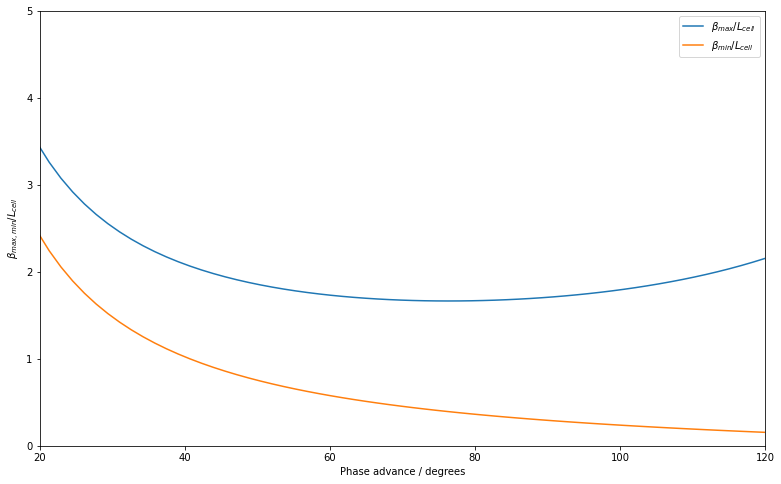

In [2]:
# Define the varaibles we want to plot
mu = np.linspace(10, 170, 100) * np.pi / 180      # Phase advance in radians
beta_max = (1+np.sin(mu/2))/np.sin(mu) # Maximum beta per unit cell length
beta_min = (1-np.sin(mu/2))/np.sin(mu) # Minimum beta per unit cell length

fig, ax1 = plt.subplots(1, 1, figsize=(13,8))

ax1.plot(mu*180/np.pi, beta_max, label=r'$\beta_{max} / L_{cell}$')
ax1.plot(mu*180/np.pi, beta_min, label=r'$\beta_{min} / L_{cell}$')

ax1.set_xlim(20, 120)
ax1.set_ylim(0, 5)

ax1.set_xlabel('Phase advance / degrees')
ax1.set_ylabel(r'$\beta_{max, min} / L_{cell}$')

ax1.legend()

Here $\beta_{max} = \frac{L_{cell}\left(1 + \sin\left(\frac{\Delta \mu_L}{2}\right)\right)}{\sin(\Delta \mu_L)}$ and
$\beta_{min} = \frac{L_{cell}\left(1 - \sin\left(\frac{\Delta \mu_L}{2}\right)\right)}{\sin(\Delta \mu_L)}$.<br>
We usually want to minimize the beam size in the ring.The beam size at a certain location (without dispersion) is given by $\sigma_{x, y}=\sqrt{\beta_{x, y}\epsilon_{x,y}}$.<br> 
If $\epsilon_{x} \ll \epsilon_{y}$ or $\varepsilon_{y} \ll \varepsilon_{x}$ (for example in an electron synchrotron), then we want to minimize $\beta_{max}$ for a given cell length. We will use ```sympy``` to solve the problem. We compute first $\frac{d \beta_{max}}{d\Delta\mu_L}$

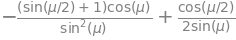

In [3]:
# Create a symbolic variable for the phase
mux = symbols('\mu', positive=True)

# Create the beta_max and beta_min function (symbolic with sympy)
beta_plus = (1 + sin(mux/2)) / sin(mux)
beta_minus = (1 - sin(mux/2)) / sin(mux)

# Compute their derivatives
beta_plus_prime = diff(beta_plus, mux)
beta_minus_prime = diff(beta_minus, mux)

# Show the beta_max derivative
display(beta_plus_prime)

And now we solve $\frac{d \beta_{max}}{d\Delta\mu_L} = 0$

Solutions for $\frac{d\beta_{max}}{d\mu} = 0$

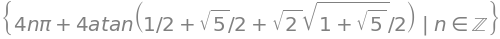

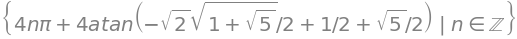

'Solution 1:  283.655 deg'

'Solution 2:  76.345 deg'

In [4]:
# Now we use sympy solver to show use the solution to dbeta_max
_n = Symbol('_n', integer=True)
solution = solveset(Eq(beta_plus_prime, 0), mux)

set1 = solution.args[0]
set2 = solution.args[1]

# Display the two sets of soltions
display(Markdown(r'Solutions for $\frac{d\beta_{max}}{d\mu} = 0$'))
display(set1)
display(set2)

# Evaluate the solution for n=0
display(f'Solution 1: {set1.lamda(0).evalf() * 180 / (np.pi): .3f} deg')
display(f'Solution 2: {set2.lamda(0).evalf() * 180 / (np.pi): .3f} deg')

***
If $\varepsilon_{x} \approx \varepsilon_{y}$, then we want to minimize $\beta_{max} + \beta_{min}$. It is much simpler:

In [5]:
_n = Symbol('_n', integer=True)
solution = solveset(Eq(beta_plus_prime + beta_minus_prime, 0), mux)

set1 = solution.args[0]
set2 = solution.args[1]

# Display the two sets of soltions
display(Markdown(r'Solutions for $\frac{d\left(\beta_{max}+\beta_{min}\right)}{d\mu} = 0$'))
display(set1)
display(set2)

# Evaluate the solution for n=0
display(f'Solution 1: {set1.lamda(0).evalf() * 180 / (np.pi): .3f} deg')
display(f'Solution 2: {set2.lamda(0).evalf() * 180 / (np.pi): .3f} deg')

Solutions for $\frac{d\left(\beta_{max}+\beta_{min}\right)}{d\mu} = 0$

'Solution 1:  90.000 deg'

'Solution 2:  270.000 deg'

## Matching the cell

We now have specific values for the phase advance we would like to reach. What should be the focal length of our quadrupoles to obtain a certain phase advance ?
We want to match the cell to a certain phase advance. We know that $\sin\left(\frac{\Delta\mu_L}{2}\right) = \frac{L_{cell}}{4f}$. Therefore $\Delta\mu_L=2\arcsin(L_{cell}L_{quad}K_1/4)$ since $K_1 = \frac{1}{fL_{quad}}$ in thin lens approximation.

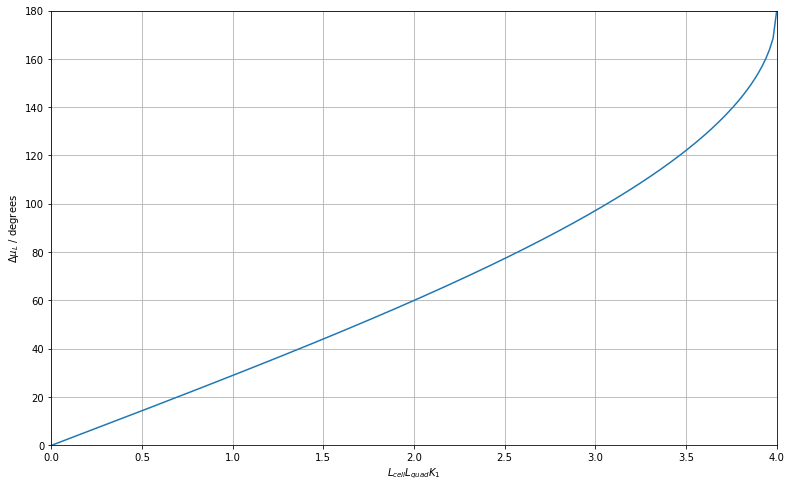

In [6]:
lcell_lquad_k1 = np.linspace(0, 4, 200)
mu_cell = 2*np.arcsin(lcell_lquad_k1/4)

fig, ax1 = plt.subplots(1, 1, figsize=(13,8))

ax1.plot(lcell_lquad_k1, mu_cell*180/np.pi)

ax1.set_xlim(0, 4)
ax1.set_ylim(0, 180)

ax1.set_xlabel('$L_{cell} L_{quad} K_1$')
ax1.set_ylabel(r'$\Delta\mu_{L}$ / degrees')

ax1.grid()

If we want a 90 degrees phase advance in our FODO cell, we must have $\sin\left(\frac{90^{\circ}}{2}\right) = \frac{L_{cell}}{4f}$.<br>
For a given cell length this gives $f = \frac{L_{cell}}{2\sqrt{2}}$ and therefore for a given quadrupole length $K_1 = \frac{2\sqrt{2}}{L_{cell}L_{quad}}$

In [7]:
######################
# MODIFY HERE        #
# FODO CELL ELEMENTS #
######################
l_cell = 10
quadrupoleLength = 1e-2

qf_position = 0
qd_position = 5

f = l_cell / (2 * np.sqrt(2))
myKf =  1/(f*quadrupoleLength) # in m^-2
myKd = -1/(f*quadrupoleLength)

particle = 'electron'
energy = 0.5 # Energy is in GeV

#####################
# END OF DEFINITION #
#####################

# The Mad-X code
myString=f'''
! *********************************************************************
! First part
! *********************************************************************

! *********************************************************************
! Definition of parameters
! *********************************************************************

l_cell={l_cell: .3f};
quadrupoleLength={quadrupoleLength: .3f};
f={f: .3f};
myKf:={myKf: .3f};// m^-2
myKd:={myKd: .3f};// m^-2

! *********************************************************************
! Definition of magnet
! ********************************************************************* 
QF: quadrupole, L=quadrupoleLength, K1:=myKf;
QD: quadrupole, L=quadrupoleLength, K1:=myKd;


! *********************************************************************
! Definition of sequence
! *********************************************************************
myCell:sequence, refer=entry, L=L_CELL;
quadrupole1: QF, at={qf_position: .3f};
quadrupole2: QD, at={qd_position: .3f};
endsequence;

! *********************************************************************
! Definition of beam
! *********************************************************************
beam, particle={particle}, energy={energy: .2f};

! *********************************************************************
! Use of the sequence
! *********************************************************************
use, sequence=myCell;
'''

myTwiss='''
! *********************************************************************
! TWISS
! *********************************************************************

title, 'Phase advance matching';
twiss, file=FODO3_phase_advance.twiss;
'''

# Assemble the input and the Twiss command, and run MAD-X
madx = Madx()
madx.input(myString+myTwiss);


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.01.11 18:13:22      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2497847307      -0.3178797763        17.05021851                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2497847307 

               dq2            betymax              dymax              dyrms 
     -0.3178797763        17.05021851                 -0                  0 

            ycomax             ycorms             deltap 

In [8]:
# We put the Mad-X twiss output in a Pandas DataFrame for easier manipulation
my_Twiss_df = madx.table.twiss.dframe()

In [9]:
# Modify the Twiss to interpolate inside the elements, and have nicer plots (the physics should not change!)
myTwiss='''
! *********************************************************************
! TWISS
! *********************************************************************
select,flag=interpolate, class=drift, slice=10, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=10, range=#s/#e;
select,flag=interpolate, class=sbend, slice=10, range=#s/#e;

twiss;
'''
madx = Madx()
madx.input(myString+myTwiss)

# The resulting Twiss table is stored in a separate DataFrame
my_HR_Twiss_df=madx.table.twiss.dframe() # HR stands for High Resolution in the s-direction


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.01.11 18:13:23      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2497847307      -0.3178797763        17.06227894                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2497847307 

               dq2            betymax              dymax              dyrms 
     -0.3178797763        17.06227894                 -0                  0 

            ycomax             ycorms             deltap 

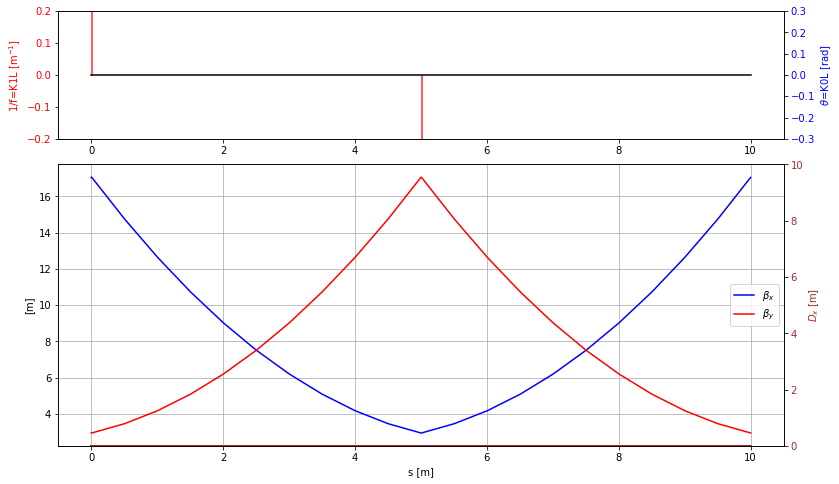

In [10]:
# Plot the results
fig = plt.figure(figsize=(13,8))
ax1 = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(my_Twiss_df['s'], 0*my_Twiss_df['s'],'k')

DF = my_Twiss_df[(my_Twiss_df['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux = DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF = my_Twiss_df[(my_Twiss_df['keyword']=='multipole')]
for i in range(len(DF)):
    aux = DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.2,.2)
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)
ax2.tick_params(axis='y', labelcolor=color)

DF = my_Twiss_df[(my_Twiss_df['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k2l, v_offset=aux.k2l/2, color='y')

DF = my_Twiss_df[(my_Twiss_df['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

    
plt.ylim(-.3,.3)

axbeta = plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(my_HR_Twiss_df['s'], my_HR_Twiss_df['betx'], 'b', label='$\\beta_x$')
plt.plot(my_HR_Twiss_df['s'], my_HR_Twiss_df['bety'], 'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx() 
plt.plot(my_HR_Twiss_df['s'], my_HR_Twiss_df['dx'], 'brown', label='$D_x$', lw=2)
ax3.set_ylabel('$D_x$ [m]', color='brown')
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(0, 10);

## Phase advance of the cell

The thin-lens phase advance

In [11]:
phase_advance = 2*np.arcsin(l_cell/(4*f))

print(f'Phase advance per cell = {phase_advance: .4f}')

Phase advance per cell =  1.5708


The MAD-X phase advance

In [12]:
print(f'MAD-X Horizontal phase advance: {madx.table.summ.Q1[0]*2*np.pi: .4f}\n')
print(f'MAD-X Vertical phase advance: {madx.table.summ.Q2[0]*2*np.pi: .4f}\n')

MAD-X Horizontal phase advance:  1.5694

MAD-X Vertical phase advance:  1.5694

